# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_026  P20382                                       13.418
Sample_092  A0A0C4DH73;P01611                            18.445
Sample_051  O95445                                       19.961
Sample_062  A0A0A0MTH0;Q8N0W4;Q8N0W4-2;Q8NFZ3;Q8NFZ3-2   16.513
Sample_205  K4DIA0;O75144;O75144-2                       19.686
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_023  P01743           13.055
Sample_100  P10124           17.080
Sample_067  J9JIG6;Q96EG1    14.400
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.916
            A0A075B6Q5                 12.608
            A0A075B6R2                 12.632
            A0A075B6S5                 12.763
            A0A087WSY4                 13.340
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   14.315
            Q9UI40;Q9UI40-2            12.848
            Q9UIW2                     11.384
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.411
            Q9UP79                     12.997
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.207,15.050,16.842,19.863,15.890,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.742,19.067,...,15.528,15.576,14.280,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.847,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.208,17.705,17.039,15.879,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.526,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.342,15.345,17.084,18.708,14.249,19.433,11.129,11.249
Sample_207,15.739,16.877,15.469,16.898,14.637,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.916,...,16.012,15.178,13.563,15.050,16.842,19.863,12.485,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.833,19.067,16.188,...,15.528,15.576,11.895,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.822,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.000,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.671,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.435,15.345,17.084,18.708,14.249,19.433,13.161,13.755
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 293.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.18it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.47it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.86it/s]

100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.15it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.28it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.25it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.60it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.13it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.98it/s]

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.27it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.89it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.63it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.39it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.32it/s]

100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

100%|██████████| 8/8 [00:02<00:00,  3.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.45it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.39it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.20it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.59it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.35it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.31it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.28it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.46it/s]

 30%|███       | 3/10 [00:01<00:02,  2.79it/s]

 40%|████      | 4/10 [00:01<00:02,  2.64it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.65it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.59it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.65it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.83it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.89it/s]

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.98it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.94it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.40it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.08it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.94it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.79it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.75it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.69it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.75it/s]

100%|██████████| 11/11 [00:03<00:00,  2.55it/s]

100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.58it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.39it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.97it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.86it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.80it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.36it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.09it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.95it/s]

100%|██████████| 12/12 [00:04<00:00,  2.17it/s]

100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.31it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.42it/s]

 31%|███       | 4/13 [00:01<00:02,  3.54it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.75it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.30it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.17it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.01it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.91it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.96it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.10it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.13it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.67it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.47it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.54it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.59it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.47it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.43it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.45it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.37it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.33it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.43it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.38it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.49it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

100%|██████████| 14/14 [00:05<00:00,  2.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.45it/s]

 20%|██        | 3/15 [00:01<00:04,  2.79it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.96it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.77it/s]

 40%|████      | 6/15 [00:02<00:03,  2.62it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.50it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.41it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.54it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.65it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.67it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.61it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.65it/s]

100%|██████████| 15/15 [00:05<00:00,  2.86it/s]

100%|██████████| 15/15 [00:05<00:00,  2.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.068 0.035          0.735 0.369       0.110   
2             0.007 0.007      0.072 0.032          0.755 0.097       0.619   
3             0.005 0.004      0.064 0.022          0.739 0.099       0.623   
4             0.006 0.006      0.090 0.033          0.775 0.086       0.724   
5             0.007 0.006      0.082 0.033          0.802 0.090       0.775   
6             0.005 0.004      0.065 0.021          0.791 0.093       0.762   
7             0.007 0.007      0.075 0.029          0.790 0.094       0.753   
8             0.006 0.005      0.072 0.025          0.827 0.089       0.812   
9             0.006 0.004      0.058 0.023          0.818 0.078       0.805   
10            0.005 0.005      0.064 0.026          0.805 0.076       0.836   
11            0.005 0.004      0.065 0.026          0.799 0.080       0.833   
12            0.005 0.004      0.052 0.020          0.799 0.083       0.830   
13            0.005 0.001      0.053 0.014          0.803 0.084       0.831   
14            0.004 0.002      0.053 0.017          0.791 0.083       0.805   
15            0.006 0.004      0.068 0.024          0.787 0.078       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.184 0.130                  0.547 0.041        0.854   
2          0.111   0.675 0.087                  0.735 0.062        0.800   
3          0.114   0.669 0.085                  0.729 0.061        0.795   
4          0.112   0.745 0.087                  0.785 0.069        0.866   
5          0.115   0.784 0.088                  0.817 0.072        0.868   
6          0.117   0.772 0.090                  0.807 0.073        0.865   
7          0.123   0.767 0.094                  0.803 0.076        0.864   
8          0.098   0.815 0.075                  0.841 0.065        0.891   
9          0.104   0.808 0.074                  0.836 0.063        0.891   
10         0.099   0.817 0.073                  0.844 0.064        0.907   
11         0.098   0.813 0.073                  0.839 0.063        0.905   
12         0.101   0.811 0.075                  0.838 0.065        0.904   
13         0.103   0.813 0.074                  0.840 0.063        0.903   
14         0.099   0.795 0.073                  0.824 0.062        0.905   
15         0.100   0.792 0.073                  0.822 0.062        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.826 0.093        210.000 0.000  
2          0.070                  0.777 0.088        210.000 0.000  
3          0.073                  0.772 0.088        210.000 0.000  
4          0.061                  0.851 0.070        210.000 0.000  
5          0.067                  0.863 0.068        210.000 0.000  
6          0.067                  0.859 0.070        210.000 0.000  
7          0.067                  0.857 0.070        210.000 0.000  
8          0.062                  0.882 0.070        210.000 0.000  
9          0.062                  0.884 0.066        210.000 0.000  
10         0.052                  0.899 0.054        210.000 0.000  
11         0.054                  0.896 0.056        210.000 0.000  
12         0.054                  0.894 0.057        210.000 0.000  
13         0.054                  0.892 0.058        210.000 0.000  
14         0.052                  0.890 0.059        210.000 0.000  
15         0.052                  0.888 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 60.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.64it/s]

100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.79it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.65it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.46it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.16it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.54it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.63it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.90it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.71it/s]

100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.93it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.40it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.35it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.37it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.49it/s]

100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.87it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.82it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.35it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.61it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.60it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.69it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.48it/s]

100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.03it/s]

 30%|███       | 3/10 [00:00<00:01,  4.08it/s]

 40%|████      | 4/10 [00:01<00:01,  3.57it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.36it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.17it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.79it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.50it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.48it/s]

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.65it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.29it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.51it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.32it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.18it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.93it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.75it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.70it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.68it/s]

100%|██████████| 11/11 [00:03<00:00,  2.33it/s]

100%|██████████| 11/11 [00:03<00:00,  2.86it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.18it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.34it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.04it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.09it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.12it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.15it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.18it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.30it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.34it/s]

100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.83it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.57it/s]

 31%|███       | 4/13 [00:01<00:03,  2.77it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.46it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.42it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.34it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.28it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.34it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.42it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.54it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.62it/s]

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.92it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.24it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.08it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.04it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.05it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.08it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.05it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.03it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.03it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.01it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.03it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.90it/s]

100%|██████████| 14/14 [00:04<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  3.11it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.26it/s]

 20%|██        | 3/15 [00:00<00:03,  3.77it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.42it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.25it/s]

 40%|████      | 6/15 [00:01<00:02,  3.19it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.24it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.10it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.93it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.82it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.89it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.84it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.81it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.59it/s]

100%|██████████| 15/15 [00:05<00:00,  2.50it/s]

100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.066 0.024          0.010 0.071       0.001   
2             0.005 0.004      0.066 0.024          0.433 0.391       0.091   
3             0.004 0.002      0.054 0.017          0.755 0.091       0.678   
4             0.005 0.003      0.055 0.017          0.760 0.090       0.692   
5             0.005 0.003      0.056 0.017          0.754 0.095       0.731   
6             0.005 0.004      0.065 0.025          0.767 0.097       0.727   
7             0.004 0.001      0.051 0.014          0.771 0.101       0.722   
8             0.004 0.004      0.049 0.024          0.772 0.100       0.721   
9             0.004 0.000      0.048 0.016          0.775 0.096       0.780   
10            0.004 0.001      0.045 0.009          0.796 0.092       0.788   
11            0.004 0.002      0.054 0.013          0.788 0.092       0.785   
12            0.005 0.003      0.055 0.016          0.793 0.088       0.782   
13            0.004 0.000      0.046 0.005          0.794 0.091       0.781   
14            0.005 0.003      0.047 0.008          0.791 0.087       0.780   
15            0.004 0.000      0.045 0.003          0.788 0.090       0.779   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.860   
2          0.099   0.142 0.139                  0.525 0.038        0.756   
3          0.110   0.710 0.084                  0.758 0.065        0.873   
4          0.109   0.720 0.079                  0.765 0.062        0.871   
5          0.112   0.738 0.087                  0.778 0.072        0.873   
6          0.111   0.742 0.084                  0.781 0.069        0.876   
7          0.111   0.741 0.087                  0.781 0.070        0.881   
8          0.109   0.741 0.084                  0.781 0.068        0.879   
9          0.107   0.773 0.080                  0.805 0.068        0.902   
10         0.108   0.787 0.078                  0.818 0.066        0.901   
11         0.108   0.782 0.079                  0.814 0.067        0.912   
12         0.108   0.783 0.080                  0.815 0.068        0.913   
13         0.110   0.782 0.080                  0.815 0.068        0.912   
14         0.110   0.781 0.080                  0.813 0.067        0.915   
15         0.108   0.778 0.077                  0.811 0.066        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.827 0.087        210.000 0.000  
2          0.121                  0.714 0.137        210.000 0.000  
3          0.056                  0.849 0.063        210.000 0.000  
4          0.056                  0.847 0.063        210.000 0.000  
5          0.056                  0.854 0.060        210.000 0.000  
6          0.054                  0.857 0.060        210.000 0.000  
7          0.056                  0.861 0.062        210.000 0.000  
8          0.056                  0.859 0.062        210.000 0.000  
9          0.051                  0.874 0.062        210.000 0.000  
10         0.051                  0.872 0.062        210.000 0.000  
11         0.047                  0.889 0.056        210.000 0.000  
12         0.047                  0.892 0.056        210.000 0.000  
13         0.048                  0.890 0.057        210.000 0.000  
14         0.046                  0.894 0.054        210.000 0.000  
15         0.046                  0.891 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 960.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.31it/s]

100%|██████████| 3/3 [00:00<00:00, 12.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.66it/s]

100%|██████████| 4/4 [00:00<00:00, 15.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 26.00it/s]

100%|██████████| 5/5 [00:00<00:00, 14.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.95it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.48it/s]

100%|██████████| 6/6 [00:00<00:00, 14.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.68it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.67it/s]

100%|██████████| 7/7 [00:00<00:00, 13.11it/s]

100%|██████████| 7/7 [00:00<00:00, 13.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 29.88it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 24.86it/s]

100%|██████████| 8/8 [00:00<00:00, 24.96it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.57it/s]

 44%|████▍     | 4/9 [00:00<00:00, 13.95it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.62it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.51it/s]

100%|██████████| 9/9 [00:00<00:00, 12.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.81it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.45it/s]

 70%|███████   | 7/10 [00:00<00:00, 16.21it/s]

 90%|█████████ | 9/10 [00:00<00:00, 15.39it/s]

100%|██████████| 10/10 [00:00<00:00, 15.44it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.48it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.90it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.91it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.34it/s]

100%|██████████| 11/11 [00:00<00:00, 12.72it/s]

100%|██████████| 11/11 [00:00<00:00, 13.17it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.36it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.04it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.88it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.84it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.25it/s]

100%|██████████| 12/12 [00:00<00:00, 13.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.52it/s]

 46%|████▌     | 6/13 [00:00<00:00, 22.75it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 20.61it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 20.95it/s]

100%|██████████| 13/13 [00:00<00:00, 21.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.70it/s]

 29%|██▊       | 4/14 [00:00<00:00, 13.86it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.55it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.37it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.60it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.14it/s]

100%|██████████| 14/14 [00:01<00:00, 12.50it/s]

100%|██████████| 14/14 [00:01<00:00, 12.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.16it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.66it/s]

 40%|████      | 6/15 [00:00<00:00, 10.55it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.38it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.04it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.07it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.66it/s]

100%|██████████| 15/15 [00:01<00:00, 11.68it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.046 0.010          0.000 0.000       0.000   
2             0.005 0.003      0.050 0.016          0.628 0.095       0.474   
3             0.005 0.003      0.054 0.017          0.629 0.106       0.427   
4             0.005 0.004      0.052 0.012          0.662 0.085       0.579   
5             0.006 0.005      0.060 0.023          0.655 0.085       0.572   
6             0.004 0.000      0.046 0.003          0.706 0.085       0.605   
7             0.004 0.001      0.043 0.007          0.715 0.090       0.615   
8             0.003 0.001      0.034 0.012          0.709 0.084       0.610   
9             0.006 0.004      0.067 0.024          0.680 0.091       0.587   
10            0.005 0.003      0.063 0.026          0.675 0.096       0.579   
11            0.005 0.004      0.065 0.027          0.689 0.096       0.599   
12            0.005 0.003      0.060 0.026          0.710 0.101       0.632   
13            0.004 0.003      0.046 0.025          0.706 0.103       0.631   
14            0.004 0.000      0.045 0.005          0.707 0.105       0.631   
15            0.003 0.001      0.032 0.009          0.699 0.104       0.633   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.749   
2          0.098   0.531 0.073                  0.630 0.050        0.697   
3          0.094   0.500 0.078                  0.616 0.053        0.699   
4          0.105   0.612 0.078                  0.680 0.060        0.777   
5          0.102   0.605 0.078                  0.675 0.059        0.773   
6          0.110   0.645 0.077                  0.708 0.056        0.797   
7          0.118   0.653 0.081                  0.715 0.060        0.793   
8          0.117   0.648 0.079                  0.712 0.059        0.791   
9          0.108   0.622 0.074                  0.689 0.056        0.785   
10         0.099   0.616 0.073                  0.684 0.058        0.781   
11         0.107   0.634 0.079                  0.698 0.060        0.780   
12         0.111   0.663 0.088                  0.719 0.071        0.797   
13         0.117   0.660 0.092                  0.717 0.072        0.792   
14         0.112   0.661 0.091                  0.717 0.072        0.791   
15         0.118   0.658 0.091                  0.715 0.071        0.791   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.693 0.085        210.000 0.000  
2          0.067                  0.659 0.072        210.000 0.000  
3          0.066                  0.655 0.074        210.000 0.000  
4          0.062                  0.743 0.068        210.000 0.000  
5          0.064                  0.739 0.069        210.000 0.000  
6          0.061                  0.760 0.071        210.000 0.000  
7          0.061                  0.758 0.073        210.000 0.000  
8          0.062                  0.742 0.084        210.000 0.000  
9          0.059                  0.734 0.084        210.000 0.000  
10         0.060                  0.732 0.086        210.000 0.000  
11         0.061                  0.736 0.083        210.000 0.000  
12         0.063                  0.746 0.085        210.000 0.000  
13         0.063                  0.743 0.084        210.000 0.000  
14         0.062                  0.739 0.083        210.000 0.000  
15         0.061                  0.739 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,1,9
score_time,4,1,9
test_precision,8,10,7
test_recall,10,10,15
test_f1,10,10,12
test_balanced_accuracy,10,10,12
test_roc_auc,10,14,6
test_average_precision,10,14,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.83it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.57it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.10it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.06it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.92it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.87it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.90it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.05it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.10it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.22it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.32it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.35it/s]

100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 28.79it/s]

100%|██████████| 6/6 [00:00<00:00, 23.62it/s]

100%|██████████| 6/6 [00:00<00:00, 24.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.62it/s]

 30%|███       | 3/10 [00:00<00:01,  5.81it/s]

 40%|████      | 4/10 [00:00<00:01,  5.13it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.77it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.51it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.32it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.29it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.56it/s]

100%|██████████| 10/10 [00:02<00:00,  4.72it/s]

100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


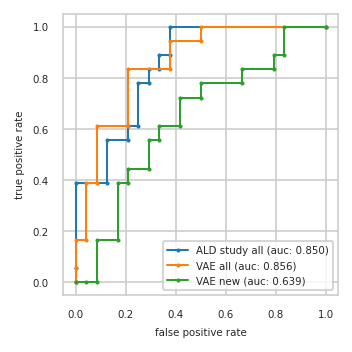

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.167   0.083 0.000
3          0.125 0.389   0.042 0.167   0.083 0.167
4          0.125 0.556   0.042 0.389   0.167 0.167
5          0.208 0.556   0.083 0.389   0.167 0.389
6          0.208 0.611   0.083 0.611   0.208 0.389
7          0.250 0.611   0.208 0.611   0.208 0.444
8          0.250 0.778   0.208 0.833   0.292 0.444
9          0.292 0.778   0.375 0.833   0.292 0.556
10         0.292 0.833   0.375 0.944   0.333 0.556
11         0.333 0.833   0.500 0.944   0.333 0.611
12         0.333 0.889   0.500 1.000   0.417 0.611
13         0.375 0.889   1.000 1.000   0.417 0.722
14         0.375 1.000     NaN   NaN   0.500 0.722
15         1.000 1.000     NaN   NaN   0.500 0.778
16           NaN   NaN     NaN   NaN   0.667 0.778
17           NaN   NaN     NaN   NaN   0.667 0.833
18           NaN   NaN     NaN   NaN   0.792 0.833
19           NaN   NaN     NaN   NaN   0.792 0.889
20           NaN   NaN     NaN   NaN   0.833 0.889
21           NaN   NaN     NaN   NaN   0.833 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,B0QYF8;P02144,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2,B1AJQ6;Q86Y82
2,G3XAP6;P49747;P49747-2,A6NNI4;G8JLH6;P21926,Q9GZT8;Q9GZT8-2
3,P02766,Q9Y2T3;Q9Y2T3-3,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
4,P61981,P61981,P31321
5,P04075,P04075,J3KSJ8;Q9UD71;Q9UD71-2
6,P14174,P14174,None
7,Q9Y2T3;Q9Y2T3-3,Q14894,None
8,P00338;P00338-3,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


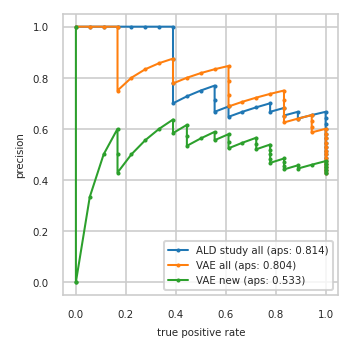

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.667 0.778     0.714 0.833     0.524 0.611
22         0.700 0.778     0.750 0.833     0.550 0.611
23         0.684 0.722     0.737 0.778     0.579 0.611
24         0.667 0.667     0.722 0.722     0.556 0.556
25         0.647 0.611     0.706 0.667     0.588 0.556
26         0.688 0.611     0.688 0.611     0.562 0.500
27         0.667 0.556     0.733 0.611     0.533 0.444
28         0.714 0.556     0.786 0.611     0.571 0.444
29         0.769 0.556     0.846 0.611     0.615 0.444
30         0.750 0.500     0.833 0.556     0.583 0.389
31         0.727 0.444     0.818 0.500     0.636 0.389
32         0.700 0.389     0.800 0.444     0.600 0.333
33         0.778 0.389     0.778 0.389     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


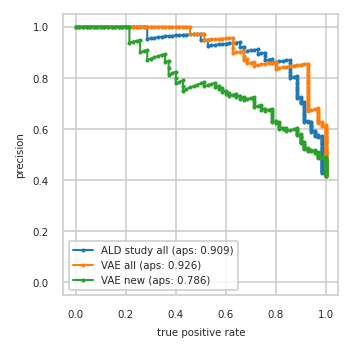

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


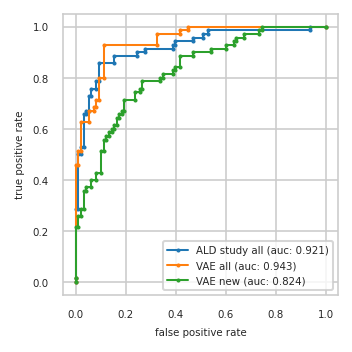

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}